In [1]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline

In [2]:
from fastai.vision import *
from fastai.callbacks import *

In [3]:
torch.cuda.is_available()

True

In [4]:
np.random.seed(42)

In [5]:
tfms=[flip_lr(p=0.5),dihedral_affine() ],[]

In [6]:
mixup=0.2

In [7]:
loss_func = LabelSmoothingCrossEntropy()

In [8]:
# class FocalLoss(nn.Module):
#     def __init__(self, alpha=1., gamma=1.):
#         super().__init__()
#         self.alpha = alpha
#         self.gamma = gamma

#     def forward(self, inputs, targets, **kwargs):
#         CE_loss = nn.CrossEntropyLoss(reduction='none')(inputs, targets)
#         pt = torch.exp(-CE_loss)
#         F_loss = self.alpha * ((1-pt)**self.gamma) * CE_loss
#         return F_loss.mean()
# loss_func = FocalLoss(gamma=2.)

In [9]:
alpha=0.99
mom=0.9
eps=1e-6

In [10]:
opt_func = partial(optim.Adam, betas=(mom,alpha), eps=eps)

In [11]:
src = (ImageList.from_folder(path='train').split_by_rand_pct(0.2).label_from_folder())

In [12]:
data = src.transform(tfms,size=(384)).databunch(bs=64).normalize()

In [13]:
learn = cnn_learner(data, models.densenet121,pretrained=False, metrics=[error_rate, accuracy, FBeta(beta=1,average='macro')],loss_func = loss_func,opt_func=opt_func,wd=1e-2)

/home/ubuntu/anaconda3/envs/snakes_breed/lib/python3.6/site-packages/torchvision/models/densenet.py:212: UserWarning: nn.init.kaiming_normal is now deprecated in favor of nn.init.kaiming_normal_.
  nn.init.kaiming_normal(m.weight.data)


In [14]:
learn= learn.mixup(alpha=mixup)

In [15]:
learn.bn_wd=False

In [16]:
learn.true_wd=True

In [17]:
learn.load('exp-7-round-1')

Learner(data=ImageDataBunch;

Train: LabelList (65934 items)
x: ImageList
Image (3, 384, 384),Image (3, 384, 384),Image (3, 384, 384),Image (3, 384, 384),Image (3, 384, 384)
y: CategoryList
class-857,class-857,class-857,class-857,class-857
Path: train;

Valid: LabelList (16483 items)
x: ImageList
Image (3, 384, 384),Image (3, 384, 384),Image (3, 384, 384),Image (3, 384, 384),Image (3, 384, 384)
y: CategoryList
class-540,class-526,class-771,class-4,class-804
Path: train;

Test: None, model=Sequential(
  (0): Sequential(
    (0): Sequential(
      (conv0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
      (norm0): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu0): ReLU(inplace)
      (pool0): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
      (denseblock1): _DenseBlock(
        (denselayer1): _DenseLayer(
          (norm1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track

In [18]:
data_448 = src.transform(tfms,size=(448)).databunch(bs=48).normalize()

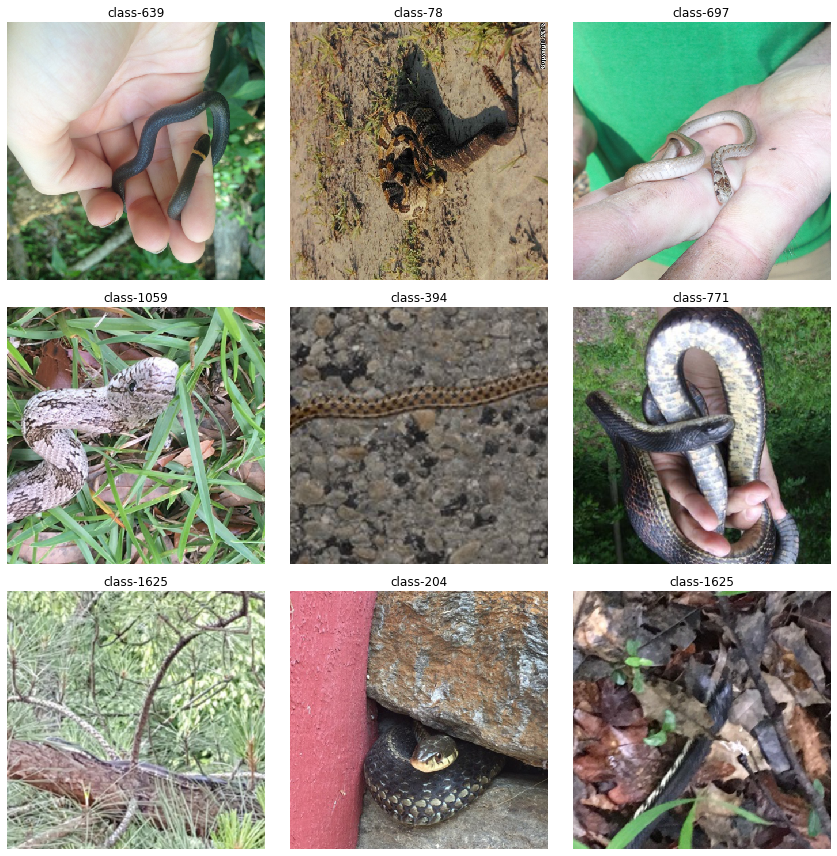

In [19]:
data_448.show_batch(rows=3, figsize=(12,12))


In [20]:
learn.data= data_448

In [21]:
learn.data

ImageDataBunch;

Train: LabelList (65934 items)
x: ImageList
Image (3, 448, 448),Image (3, 448, 448),Image (3, 448, 448),Image (3, 448, 448),Image (3, 448, 448)
y: CategoryList
class-857,class-857,class-857,class-857,class-857
Path: train;

Valid: LabelList (16483 items)
x: ImageList
Image (3, 448, 448),Image (3, 448, 448),Image (3, 448, 448),Image (3, 448, 448),Image (3, 448, 448)
y: CategoryList
class-540,class-526,class-771,class-4,class-804
Path: train;

Test: None

In [22]:
learn.load('exp-8-round-1')

Learner(data=ImageDataBunch;

Train: LabelList (65934 items)
x: ImageList
Image (3, 448, 448),Image (3, 448, 448),Image (3, 448, 448),Image (3, 448, 448),Image (3, 448, 448)
y: CategoryList
class-857,class-857,class-857,class-857,class-857
Path: train;

Valid: LabelList (16483 items)
x: ImageList
Image (3, 448, 448),Image (3, 448, 448),Image (3, 448, 448),Image (3, 448, 448),Image (3, 448, 448)
y: CategoryList
class-540,class-526,class-771,class-4,class-804
Path: train;

Test: None, model=Sequential(
  (0): Sequential(
    (0): Sequential(
      (conv0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
      (norm0): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu0): ReLU(inplace)
      (pool0): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
      (denseblock1): _DenseBlock(
        (denselayer1): _DenseLayer(
          (norm1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track

In [23]:
learn = learn.to_fp16(dynamic=True)

In [24]:
learn.unfreeze()

In [26]:
learn.lr_find()

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


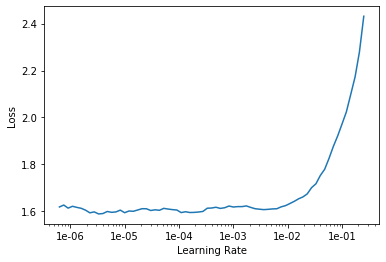

In [27]:
learn.recorder.plot()

In [28]:
lr=1e-4

In [29]:
learn.fit_one_cycle(1, lr, div_factor=10, pct_start=0.3)

epoch,train_loss,valid_loss,error_rate,accuracy,f_beta,time
0,1.607531,1.415635,0.243099,0.756901,0.713027,15:13


In [30]:
learn.save('exp-8-round-2')

In [31]:
interp = ClassificationInterpretation.from_learner(learn)

losses,idxs = interp.top_losses()

len(data.valid_ds)==len(losses)==len(idxs)

True

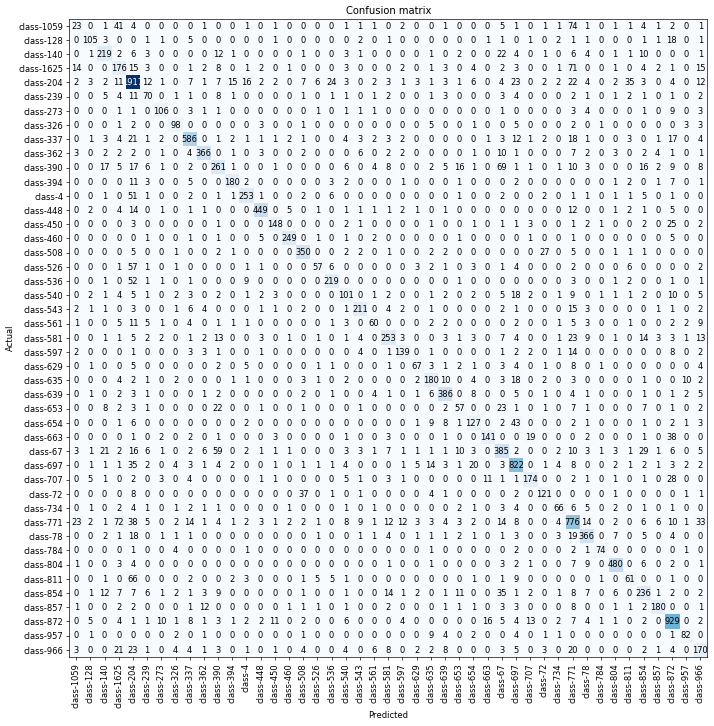

In [33]:
interp.plot_confusion_matrix(figsize=(12,12), dpi=60)


In [34]:
interp.most_confused(min_val=2)


[('class-1059', 'class-771', 74),
 ('class-771', 'class-1625', 72),
 ('class-1625', 'class-771', 71),
 ('class-390', 'class-67', 69),
 ('class-811', 'class-204', 66),
 ('class-67', 'class-390', 59),
 ('class-526', 'class-204', 57),
 ('class-536', 'class-204', 52),
 ('class-4', 'class-204', 51),
 ('class-654', 'class-697', 43),
 ('class-1059', 'class-1625', 41),
 ('class-663', 'class-872', 38),
 ('class-771', 'class-204', 38),
 ('class-72', 'class-508', 37),
 ('class-204', 'class-811', 35),
 ('class-697', 'class-204', 35),
 ('class-854', 'class-67', 35),
 ('class-771', 'class-966', 33),
 ('class-67', 'class-854', 29),
 ('class-707', 'class-872', 28),
 ('class-508', 'class-72', 27),
 ('class-450', 'class-872', 25),
 ('class-204', 'class-536', 24),
 ('class-204', 'class-697', 23),
 ('class-581', 'class-771', 23),
 ('class-653', 'class-67', 23),
 ('class-771', 'class-1059', 23),
 ('class-966', 'class-204', 23),
 ('class-140', 'class-67', 22),
 ('class-204', 'class-771', 22),
 ('class-653',

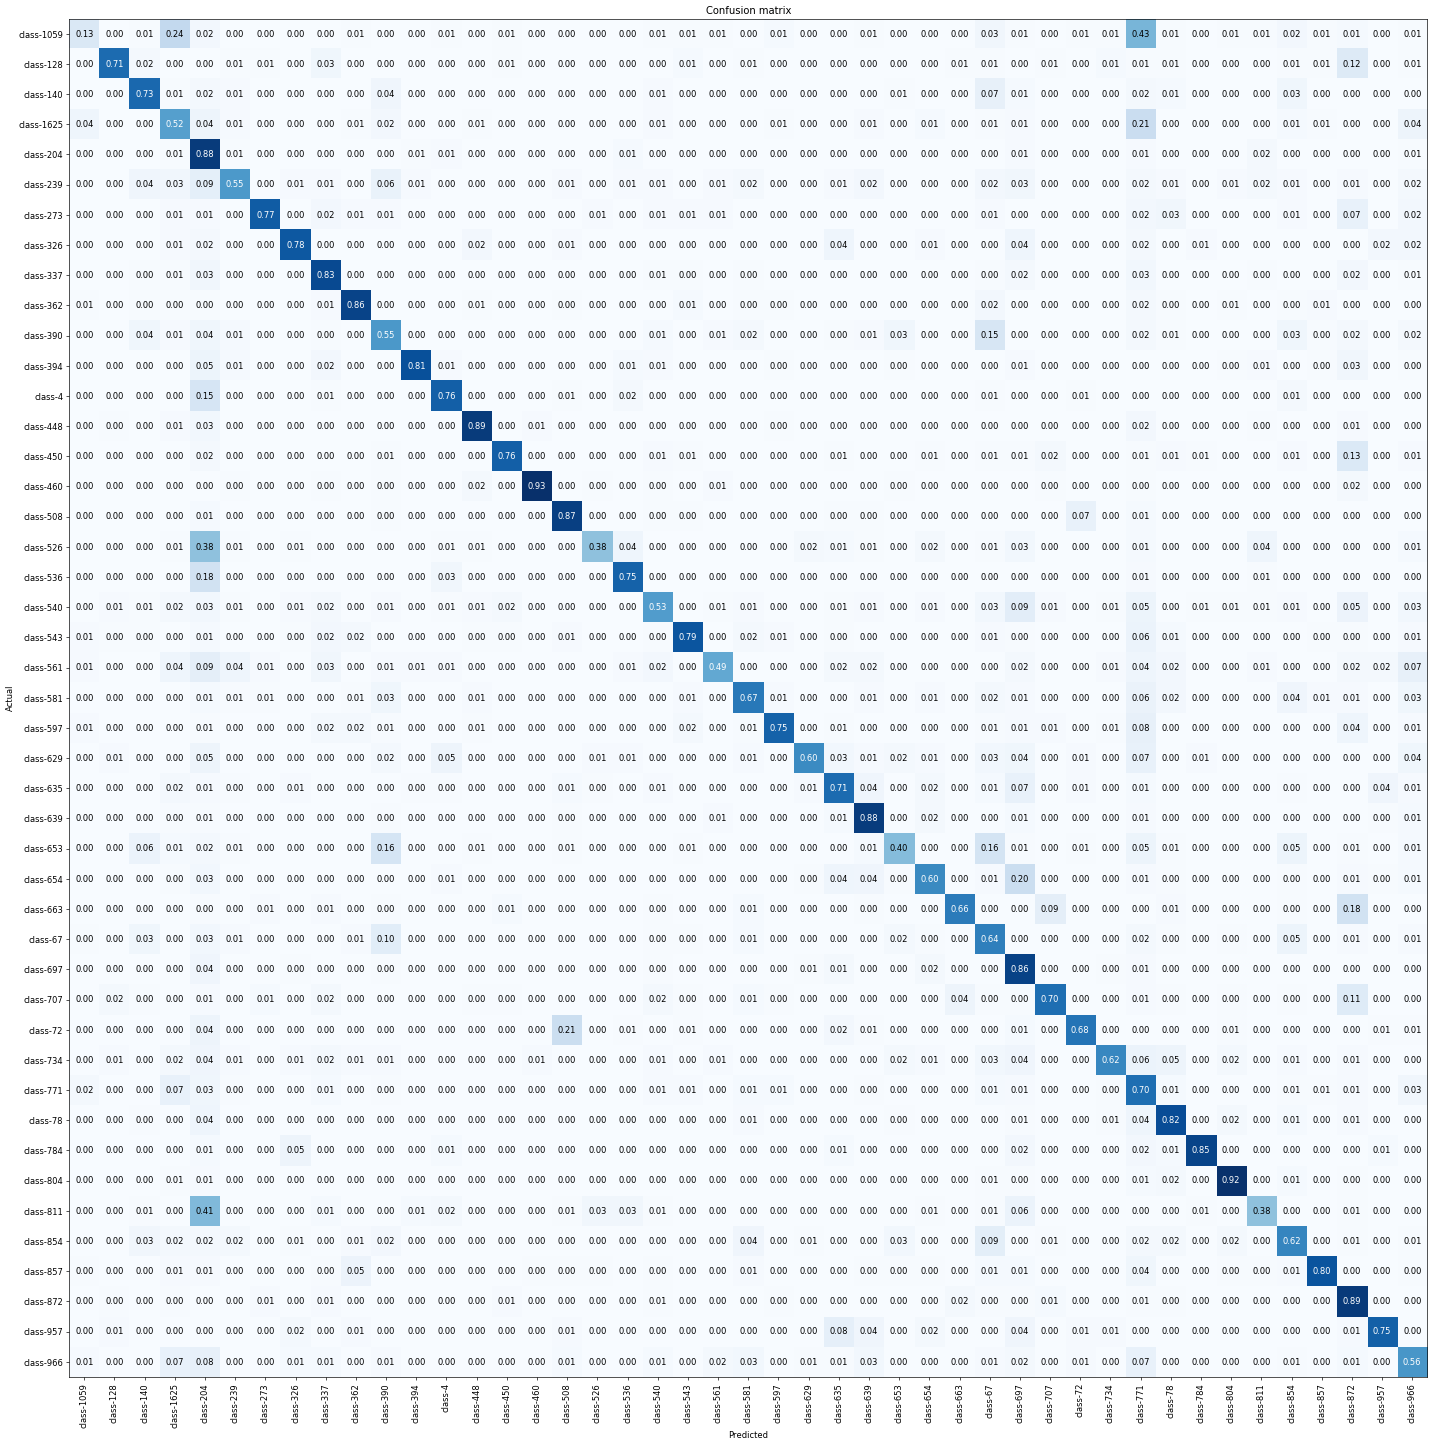

In [35]:
interp.plot_confusion_matrix(figsize=(24,24), dpi=60,normalize=True)
